In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('analyze.csv')
df.drop_duplicates(inplace=True)    # 去重
# x = df.drop(columns = ['SeriousDlqin2yrs'])
# y = df['SeriousDlqin2yrs']
columns = df.columns.tolist()
columns.remove('SeriousDlqin2yrs')

WOE分箱
取值分箱

In [3]:
cut1 = pd.qcut(df["RevolvingUtilizationOfUnsecuredLines"], 4, labels=False)
cut2 = pd.qcut(df["age"], 8, labels=False)
bins3 = [-1,0,1,3,5,13]
cut3 = pd.cut(df["NumberOfTime30-59DaysPastDueNotWorse"], bins3, labels=False)
cut4 = pd.qcut(df["DebtRatio"], 3, labels=False)
cut5 = pd.qcut(df["MonthlyIncome"], 4, labels=False)
cut6 = pd.qcut(df["NumberOfOpenCreditLinesAndLoans"], 4, labels=False)
bins7 = [-1, 0, 1, 3, 5, 20]
cut7 = pd.cut(df["NumberOfTimes90DaysLate"], bins7, labels=False)
bins8 = [-1, 0, 1, 2, 3, 54]
cut8 = pd.cut(df["NumberRealEstateLoansOrLines"], bins8, labels=False)
bins9 = [-1, 0, 1, 3, 12]
cut9 = pd.cut(df["NumberOfTime60-89DaysPastDueNotWorse"], bins9, labels=False)
bins10 = [-1, 0, 1, 2, 3, 5, 21]
cut10 = pd.cut(df["NumberOfDependents"], bins10, labels=False)

WOE值计算

In [4]:
rate = df["SeriousDlqin2yrs"].sum() / (df["SeriousDlqin2yrs"].count() - df["SeriousDlqin2yrs"].sum())
def get_woe_data(cut):
    grouped = df["SeriousDlqin2yrs"].groupby(cut, as_index=True).value_counts()
    woe = np.log(grouped.unstack().iloc[:,1] / grouped.unstack().iloc[:, 0] / rate)
    return woe
cut1_woe = get_woe_data(cut1)
cut2_woe = get_woe_data(cut2)
cut3_woe = get_woe_data(cut3)
cut4_woe = get_woe_data(cut4)
cut5_woe = get_woe_data(cut5)
cut6_woe = get_woe_data(cut6)
cut7_woe = get_woe_data(cut7)
cut8_woe = get_woe_data(cut8)
print(cut8_woe)
cut9_woe = get_woe_data(cut9)
cut10_woe = get_woe_data(cut10)

NumberRealEstateLoansOrLines
0    0.235478
1   -0.245347
2   -0.187261
3    0.005120
4    0.594782
dtype: float64


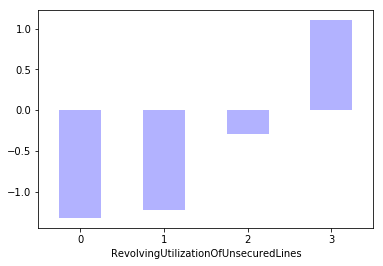

In [5]:
cut1_woe.plot.bar(color='b', alpha=0.3, rot=0)

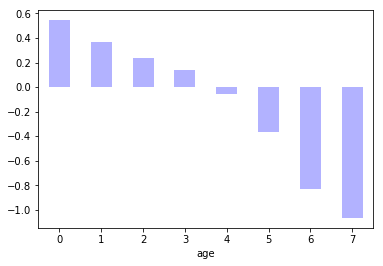

In [6]:
cut2_woe.plot.bar(color='b', alpha=0.3, rot=0)

看出woe已调整到具有单调性

In [7]:
def get_IV_data(cut, cut_woe):
    grouped = df["SeriousDlqin2yrs"].groupby(cut,as_index=True).value_counts()
    tmp1 = grouped.unstack().iloc[:,1]
    tmp2 = df["SeriousDlqin2yrs"].sum()
    cut_IV = ((tmp1 / tmp2 - tmp1 / (df["SeriousDlqin2yrs"].count() - tmp2)) * cut_woe).sum()    
    return cut_IV

#计算各分组的IV值
cut1_IV = get_IV_data(cut1, cut1_woe)
cut2_IV = get_IV_data(cut2, cut2_woe)
cut3_IV = get_IV_data(cut3, cut3_woe)
cut4_IV = get_IV_data(cut4, cut4_woe)
cut5_IV = get_IV_data(cut5, cut5_woe)
cut6_IV = get_IV_data(cut6, cut6_woe)
cut7_IV = get_IV_data(cut7, cut7_woe)
cut8_IV = get_IV_data(cut8, cut8_woe)
cut9_IV = get_IV_data(cut9, cut9_woe)
cut10_IV = get_IV_data(cut10, cut10_woe)
IV = pd.DataFrame([cut1_IV, cut2_IV, cut3_IV, cut4_IV, cut5_IV, cut6_IV, cut7_IV, cut8_IV, cut9_IV, cut10_IV],
                  index=columns, columns=['IV'])
# ax = IV.plot.bar(color='b', alpha=0.3, rot=30, figsize=(15, 5), fontsize=(10))
# ax.set_title('特征变量与IV值分布图',fontsize=(15))
# ax.set_xlabel('特征变量',fontsize=(15))
# ax.set_ylabel('IV',fontsize=(15))
IV

,IV
RevolvingUtilizationOfUnsecuredLines,0.453200
age,0.104069
NumberOfTime30-59DaysPastDueNotWorse,0.392537
DebtRatio,0.009029
MonthlyIncome,0.030547
NumberOfOpenCreditLinesAndLoans,0.017495
NumberOfTimes90DaysLate,0.515579
NumberRealEstateLoansOrLines,0.028255
NumberOfTime60-89DaysPastDueNotWorse,0.336916
NumberOfDependents,0.016496


一般选取IV大于0.02的特征变量进行后续训练，从以上可以看出所有变量均满足，所以选取全部的

WOE值替换

In [8]:
df_woe = pd.DataFrame()
def replace_data(cut, cut_woe):
    a = []
    for i in cut.unique():
        a.append(i)
        a.sort()
    for m in range(len(a)):
        cut.replace(a[m], cut_woe.values[m], inplace=True)
    return cut

df_woe["SeriousDlqin2yrs"] = df["SeriousDlqin2yrs"]
df_woe["RevolvingUtilizationOfUnsecuredLines"] = replace_data(cut1, cut1_woe)
df_woe["age"] = replace_data(cut2, cut2_woe)
df_woe["NumberOfTime30-59DaysPastDueNotWorse"]  =  replace_data(cut3, cut3_woe)
df_woe["DebtRatio"]  =  replace_data(cut4, cut4_woe)
df_woe["MonthlyIncome"] = replace_data(cut5, cut5_woe)
df_woe["NumberOfOpenCreditLinesAndLoans"] = replace_data(cut6, cut6_woe)
df_woe["NumberOfTimes90DaysLate"] = replace_data(cut7, cut7_woe)
df_woe["NumberRealEstateLoansOrLines"] = replace_data(cut8, cut8_woe)
df_woe["NumberOfTime60-89DaysPastDueNotWorse"] = replace_data(cut9, cut9_woe)
df_woe["NumberOfDependents"] = replace_data(cut10, cut10_woe)
df_woe.head()

3
2
0
1
2
1
0
3
7
4
6
5
2
0
1
3
4
2
0
1
3
0
2
1
3
0
1
2
0
1
2
3
4
4
0
1
3
2
0
1
2
3
2
1
0
3
4
5


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1.101834,0.238509,1.735033,0.181979,-0.371651,-0.012742,-0.375256,0.594782,-0.272953,0.202612
1,0,1.101834,0.365959,-0.527540,-0.131963,0.313050,0.251244,-0.375256,0.235478,-0.272953,0.096812
2,0,1.101834,0.365959,0.903415,-0.131963,0.313050,0.251244,1.965152,0.235478,-0.272953,-0.153553
3,0,-0.294389,0.544728,-0.527540,-0.131963,0.313050,0.251244,-0.375256,0.235478,-0.272953,-0.153553
4,0,1.101834,0.142952,0.903415,-0.131963,-0.371651,-0.227685,-0.375256,-0.245347,-0.272953,-0.153553


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x = df_woe.iloc[:,1:]
y = df_woe.iloc[:,:1].values.ravel()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.6,random_state=0)
model = LogisticRegression(solver='liblinear')
clf = model.fit(x_train,y_train)
print('测试成绩：{}'.format(clf.score(x_test,y_test)))

测试成绩：0.9365346909291046


In [10]:
coe = clf.coef_        #特征权值系数，后面转换为打分规则时会用到
coe

array([[ 0.57684127,  0.46468942,  0.57275774,  1.1002474 ,  0.36439119,
        -0.08197267,  0.5674546 ,  0.79250196,  0.40374589,  0.30745006]])

In [11]:
y_pred = clf.predict(x_test)

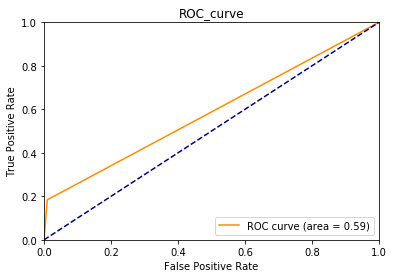

0.5871548442433668

In [12]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()
roc_auc 

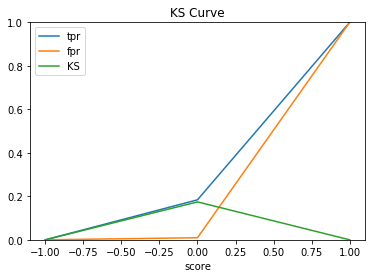

<Figure size 1440x1440 with 0 Axes>

In [13]:
fig, ax = plt.subplots() 
ax.plot(1 - threshold, tpr, label='tpr') # ks曲线要按照预测概率降序排列，所以需要1-threshold镜像 
ax.plot(1 - threshold, fpr, label='fpr') 
ax.plot(1 - threshold, tpr-fpr,label='KS') 
plt.xlabel('score') 
plt.title('KS Curve') 
plt.ylim([0.0, 1.0]) 
plt.figure(figsize=(20,20)) 
legend = ax.legend(loc='upper left') 
plt.show()

In [14]:
max(tpr - fpr)

0.1743096884867338

模型结果转评分

In [15]:
factor = 20 / np.log(2)
offset = 600 - 20 * np.log(20) / np.log(2)
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores
x1 = get_score(coe[0][0], cut1_woe, factor)
x2 = get_score(coe[0][1], cut2_woe, factor)
x3 = get_score(coe[0][2], cut3_woe, factor)
x4 = get_score(coe[0][3], cut4_woe, factor)
x5 = get_score(coe[0][4], cut5_woe, factor)
x6 = get_score(coe[0][5], cut6_woe, factor)
x7 = get_score(coe[0][6], cut7_woe, factor)
x8 = get_score(coe[0][7], cut8_woe, factor)
x9 = get_score(coe[0][8], cut9_woe, factor)
x10 = get_score(coe[0][9], cut10_woe, factor)
print("RevolvingUtilizationOfUnsecuredLines score:{}".format(x1))
print("age score:{}".format(x2))
print("NumberOfTime30-59DaysPastDueNotWorse score:{}".format(x3))
print("DebtRatio score:{}".format(x4))
print("MonthlyIncome:{}".format(x5))
print("NumberOfOpenCreditLinesAndLoans score:{}".format(x6))
print("NumberOfTimes90DaysLate score:{}".format(x7))
print("NumberRealEstateLoansOrLines score:{}".format(x8))
print("NumberOfTime60-89DaysPastDueNotWorse score:{}".format(x9))
print("NumberOfDependents score:{}".format(x10))

RevolvingUtilizationOfUnsecuredLines score:[-22.0, -20.0, -5.0, 18.0]
age score:[7.0, 5.0, 3.0, 2.0, -1.0, -5.0, -11.0, -14.0]
NumberOfTime30-59DaysPastDueNotWorse score:[-9.0, 15.0, 29.0, 39.0, 44.0]
DebtRatio score:[-4.0, -2.0, 6.0]
MonthlyIncome:[3.0, 1.0, -2.0, -4.0]
NumberOfOpenCreditLinesAndLoans score:[-1.0, 1.0, 0.0, 0.0]
NumberOfTimes90DaysLate score:[-6.0, 32.0, 45.0, 54.0, 54.0]
NumberRealEstateLoansOrLines score:[5.0, -6.0, -4.0, 0.0, 14.0]
NumberOfTime60-89DaysPastDueNotWorse score:[-3.0, 21.0, 31.0, 37.0]
NumberOfDependents score:[-1.0, 1.0, 2.0, 3.0, 4.0, 6.0]


计算用户总分

In [16]:
def compute_score(series,bins,score):
    list = []
    i = 0
    while i < len(series):
        value = series[i]
        j = len(bins) - 2
        m = len(bins) - 2
        while j >= 0:
            if value >= bins[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(score[m])
        i += 1
    return list
# test1 = pd.read_csv(path2)
# test1['x1'] = pd.Series(compute_score(test1['RevolvingUtilizationOfUnsecuredLines'], bins1, x1))
# test1['x2'] = pd.Series(compute_score(test1['age'], bins2, x2))
# test1['x3'] = pd.Series(compute_score(test1['NumberOfTime30-59DaysPastDueNotWorse'], bins3, x3))
# test1['x4'] = pd.Series(compute_score(test1['DebtRatio'], bins4, x4))
# test1['x5'] = pd.Series(compute_score(test1['MonthlyIncome'], bins5, x5))
# test1['x6'] = pd.Series(compute_score(test1['NumberOfOpenCreditLinesAndLoans'], bins6, x6))
# test1['x7'] = pd.Series(compute_score(test1['NumberOfTimes90DaysLate'], bins7, x7))
# test1['x8'] = pd.Series(compute_score(test1['NumberRealEstateLoansOrLines'], bins8, x8))
# test1['x9'] = pd.Series(compute_score(test1['NumberOfTime60-89DaysPastDueNotWorse'], bins9, x9))
# test1['x10'] = pd.Series(compute_score(test1['NumberOfDependents'], bins10, x10))
# test1['Score'] = test1['x1']+test1['x2']+test1['x3']+test1['x4']+test1['x5']+test1['x6']+test1['x7']+test1['x8']+test1['x9']+test1['x10']+600
# test1.to_csv(, index=False)